In [633]:
import yfinance as yf
import numpy as np
import pandas as pd

# Download stock data
data = yf.download("AAPL", start="2020-01-01", end="2024-01-01")

# Check the structure of the data
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.716080,72.776606,71.466820,71.721026,135480400
2020-01-03,72.009117,72.771745,71.783962,71.941328,146322800
2020-01-06,72.582901,72.621639,70.876068,71.127858,118387200
2020-01-07,72.241547,72.849224,72.021231,72.592594,108872000
2020-01-08,73.403648,73.706279,71.943759,71.943759,132079200


In [634]:
data['Close_t-1'] = data['Close'].shift(1)
data['Close_t-2'] = data['Close'].shift(2)
data['Close_t-3'] = data['Close'].shift(3)
data['Close_t-4'] = data['Close'].shift(4)
data['Close_t-5'] = data['Close'].shift(4)

data = data.drop(['Open','High','Low', 'Volume'], axis=1)

# Drop the rows with NaN values (the first 4 rows in this case)
data.dropna(inplace=True)

data

Price,Close,Close_t-1,Close_t-2,Close_t-3,Close_t-4,Close_t-5
Ticker,AAPL,,,,,
Date,,,,,,
2020-01-08,73.403648,72.241547,72.582901,72.009117,72.716080,72.716080
2020-01-09,74.962799,73.403648,72.241547,72.582901,72.009117,72.009117
2020-01-10,75.132271,74.962799,73.403648,72.241547,72.582901,72.582901
2020-01-13,76.737419,75.132271,74.962799,73.403648,72.241547,72.241547
2020-01-14,75.701225,76.737419,75.132271,74.962799,73.403648,73.403648
...,...,...,...,...,...,...
2023-12-22,192.444580,193.518112,193.667252,195.764664,194.720901,194.720901
2023-12-26,191.897873,192.444580,193.518112,193.667252,195.764664,195.764664


In [635]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

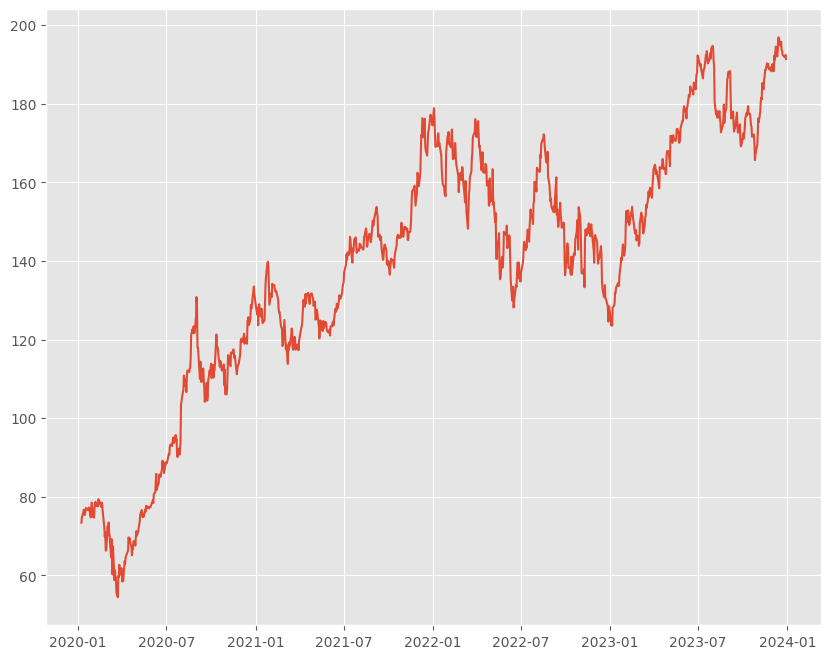

In [636]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10, 8)

plt.plot(data.index, data['Close'])

In [ ]:
# Assuming df is your DataFrame with 'log_ret' as the target (y) and the other columns as features (x)

# Features (x) and target (y)
x = data.drop(['Close'], axis=1).values
y = data['Close'].values

# Train/test split with no shuffle
x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.2, shuffle=False)

# Convert to torch tensors and add an extra dimension
x_tr = torch.FloatTensor(x_tr)
y_tr = torch.FloatTensor(y_tr)
x_te = torch.FloatTensor(x_te)
y_te = torch.FloatTensor(y_te)

x_te.shape

NameError: name 'data' is not defined

In [638]:
class MeanFieldLayer(nn.Module):
    """Represents a mean-field Gaussian distribution over each layer of the network."""

    def __init__(self, input_dim, output_dim, init_var=1e-3, prior_var = 1e-4):
        super(MeanFieldLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        # Prior parameters p(theta)
        self.w_mu_p = torch.zeros(input_dim, output_dim)
        self.w_log_var_p = torch.ones(input_dim, output_dim) * torch.log(torch.tensor(prior_var))
        self.b_mu_p = torch.zeros(output_dim)
        self.b_log_var_p = torch.ones(output_dim) * torch.log(torch.tensor(prior_var))

        # Variational parameters q(theta)
        self.w_mu_q = nn.Parameter(torch.zeros(input_dim, output_dim), requires_grad=True)
        self.w_log_var_q = nn.Parameter(
            torch.ones(input_dim, output_dim) * torch.log(torch.tensor(prior_var)), requires_grad=True
        )  
        self.b_mu_q = nn.Parameter(torch.zeros(output_dim), requires_grad=True)
        self.b_log_var_q = nn.Parameter(
            torch.ones(output_dim) * torch.log(torch.tensor(prior_var)), requires_grad=True
        )

    # the priors do not change so could be stored as attributes, but
    # it feels cleaner to access them in the same way as the posteriors
    def p_w(self):
        """weight prior distribution"""
        return torch.distributions.Normal(self.w_mu_p, (0.5 * self.w_log_var_p).exp())

    def p_b(self):
        """bias prior distribution"""
        return torch.distributions.Normal(self.b_mu_p, (0.5 * self.b_log_var_p).exp())

    def q_w(self):
        """variational weight posterior"""
        return torch.distributions.Normal(self.w_mu_q, (0.5 * self.w_log_var_q).exp())

    def q_b(self):
        """variational bias posterior"""
        return torch.distributions.Normal(self.b_mu_q, (0.5 * self.b_log_var_q).exp())

    def kl(self):
        weight_kl = torch.distributions.kl.kl_divergence(self.q_w(), self.p_w()).sum() 
        bias_kl = torch.distributions.kl.kl_divergence(self.q_b(), self.p_b()).sum()
        return weight_kl + bias_kl

    def forward(self, x):
        """Propagates x through this layer by sampling weights from the posterior"""
        assert (len(x.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        assert x.shape[-1] == self.input_dim

        num_samples = x.shape[0]
        # rsample carries out reparameterisation trick for us   
        weights = self.q_w().rsample((num_samples,))  # (num_samples, input_dim, output_dim).
        # print('dim weights', weights.shape)

        biases = self.q_b().rsample((num_samples,)).unsqueeze(1)  # (num_samples, batch_size, output_dim)
        return x @ weights + biases # (num_samples, batch_size, output_dim).



class MeanFieldBNN(nn.Module):
    """Mean-field variational inference BNN."""

    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        activation=nn.ELU(),
        noise_std=1.0,
        prior_var = 1e-4
    ):
        super(MeanFieldBNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.activation = activation
        self.log_noise_var = 0.5*torch.log(torch.tensor(noise_std))

        self.network = nn.ModuleList()
        for i in range(len(hidden_dims) + 1):
            if i == 0:
                self.network.append(MeanFieldLayer(self.input_dim, self.hidden_dims[i], prior_var = prior_var))
                self.network.append(self.activation)
            elif i == len(hidden_dims):
                self.network.append(
                    MeanFieldLayer(self.hidden_dims[i - 1], self.output_dim,prior_var = prior_var)
                )
            else:
                self.network.append(
                    MeanFieldLayer(self.hidden_dims[i - 1], self.hidden_dims[i],prior_var = prior_var)
                )
                self.network.append(self.activation) 

    def forward(self, x, num_samples=1):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """
        assert len(x.shape) == 2, "x.shape must be (batch_size, input_dim)."

        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        x = torch.unsqueeze(x, 0).repeat(num_samples, 1, 1)
        # Propagate x through network
        for layer in self.network:
            x = layer(x)

        assert len(x.shape) == 3, "x.shape must be (num_samples, batch_size, output_dim)"
        assert x.shape[-1] == self.output_dim

        return x

    def ll(self, y_obs, y_pred, num_samples=1):
        """Computes the log likelihood of the outputs of self.forward(x)"""
        l = torch.distributions.normal.Normal(y_pred, torch.sqrt(torch.exp(self.log_noise_var)))
        
        # take mean over num_samples dim, sum over batch_size dim
        # note that after taking mean, batch_size becomes dim 0
        return l.log_prob(y_obs.unsqueeze(0).repeat(num_samples, 1, 1)).mean(0).sum(0).squeeze()

    def kl(self):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl() for layer in self.network if isinstance(layer, MeanFieldLayer)])

    def loss(self, x, y, num_samples=1):
        """Computes the ELBO and returns its negative"""

        y_pred = self.forward(x, num_samples=num_samples)
        
        exp_ll = self.ll(y, y_pred, num_samples=num_samples)
        kl = self.kl()

        return kl - exp_ll, exp_ll, kl

MeanFieldBNN(
  (activation): ELU(alpha=1.0)
  (network): ModuleList(
    (0): MeanFieldLayer()
    (1): ELU(alpha=1.0)
    (2): MeanFieldLayer()
    (3): ELU(alpha=1.0)
    (4): MeanFieldLayer()
  )
)


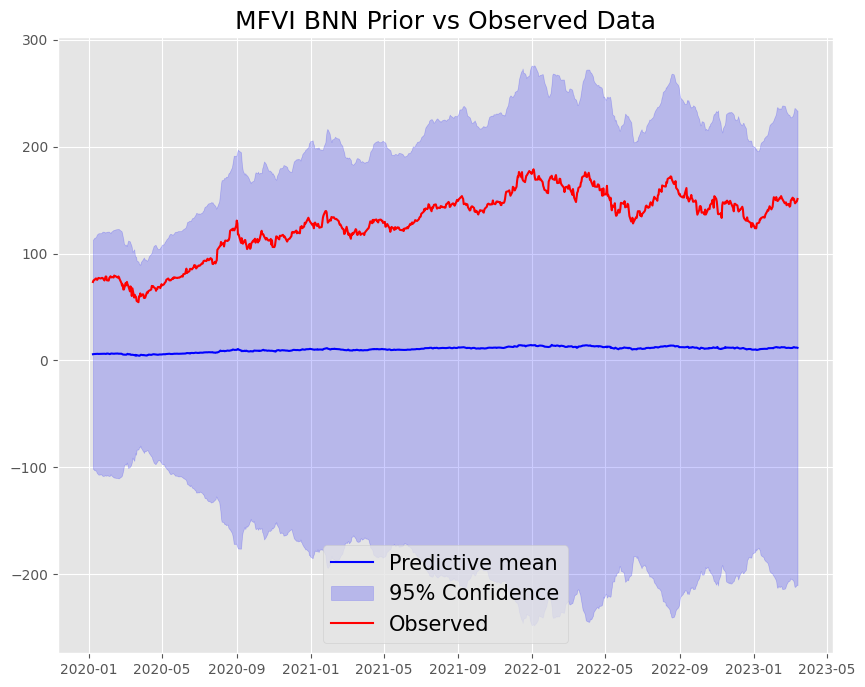

In [639]:
bnn_model = MeanFieldBNN(5, [20, 20], 1, noise_std=0.5, prior_var=0.1)
# find value of noise_std that works best by trial and error, but this is of course
# inherently a bit contrived since we know we set input noise std to 0.15 in dataset generation
print(bnn_model)

opt = torch.optim.Adam(
    bnn_model.parameters(),
    lr = 1e-2
)

preds = bnn_model(x_tr, num_samples=100).squeeze(-1).detach().numpy()
pred_mean = preds.mean(0)
pred_std = preds.std(0)
plt.plot(data.index[:len(pred_mean)], pred_mean, color='blue', label='Predictive mean')
plt.fill_between(data.index[:len(pred_mean)], pred_mean + 1.96*pred_std, pred_mean - 1.96*pred_std, color='blue', alpha=0.2, label='95% Confidence')

plt.title("MFVI BNN Prior vs Observed Data", fontsize=18)
plt.plot(data.index[:len(pred_mean)], y_tr, color='red', label='Observed', zorder=900)
plt.legend(fontsize=15, loc='lower center')
plt.show()

100%|██████████| 4000/4000 [00:08<00:00, 453.11it/s]


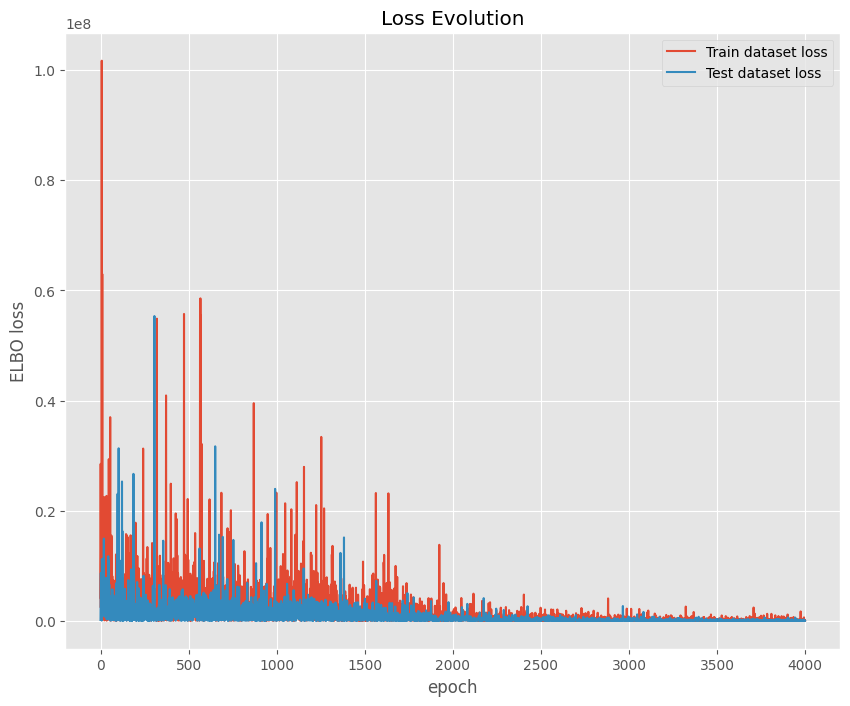

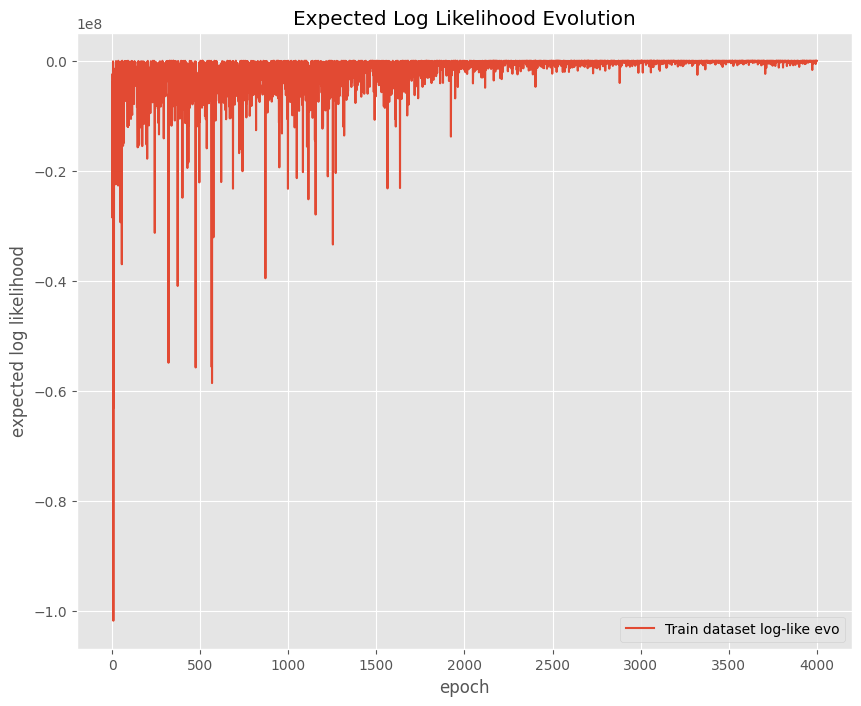

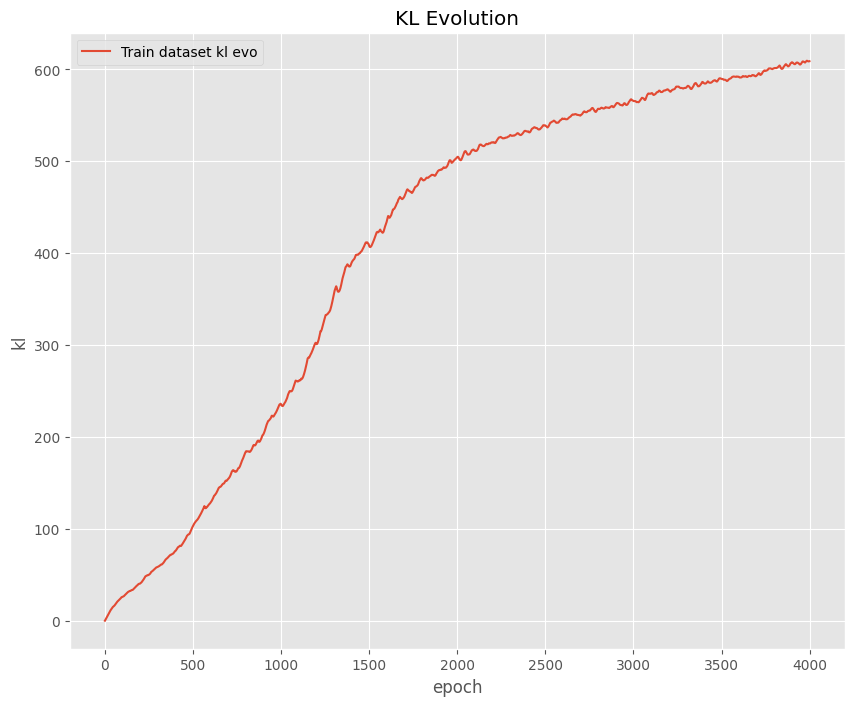

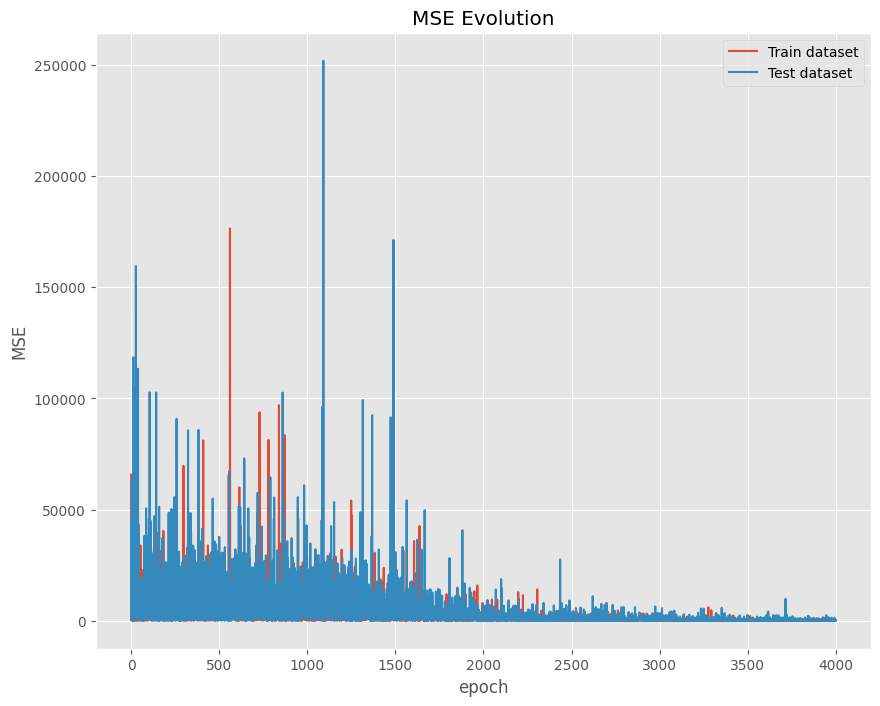

In [640]:
tr_loss_evo = []
tr_ll_evo = []
tr_kl_evo = []
te_loss_evo = []

tr_mse_loss_evo = []
te_mse_loss_evo = []
aux_loss = nn.MSELoss()

for epoch in tqdm(range(4000)):  # epochs
    opt.zero_grad()

    l, ll, kl = bnn_model.loss(x_tr, y_tr, num_samples=1)
    tr_loss_evo.append(l.item())
    tr_ll_evo.append(ll.item())
    tr_kl_evo.append(kl.item())
    tr_mse_loss_evo.append(aux_loss(bnn_model(x_tr), y_tr.unsqueeze(0)).item())

    te_loss_evo.append(bnn_model.loss(x_te, y_te)[0].item())
    te_mse_loss_evo.append(aux_loss(bnn_model(x_te), y_te.unsqueeze(0)).item())

    l.backward()
    opt.step()

plt.plot(tr_loss_evo, label='Train dataset loss')
plt.plot(te_loss_evo, label='Test dataset loss')
plt.ylabel('ELBO loss')
plt.xlabel('epoch')
plt.legend()
plt.title('Loss Evolution')
plt.show()

plt.plot(tr_ll_evo, label='Train dataset log-like evo')
plt.ylabel('expected log likelihood')
plt.xlabel('epoch')
plt.legend()
plt.title('Expected Log Likelihood Evolution')
plt.show()

plt.plot(tr_kl_evo, label='Train dataset kl evo')
plt.ylabel('kl')
plt.xlabel('epoch')
plt.legend()
plt.title('KL Evolution')
plt.show()

plt.plot(tr_mse_loss_evo, label='Train dataset')
plt.plot(te_mse_loss_evo, label='Test dataset')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend()
plt.title('MSE Evolution')
plt.show()

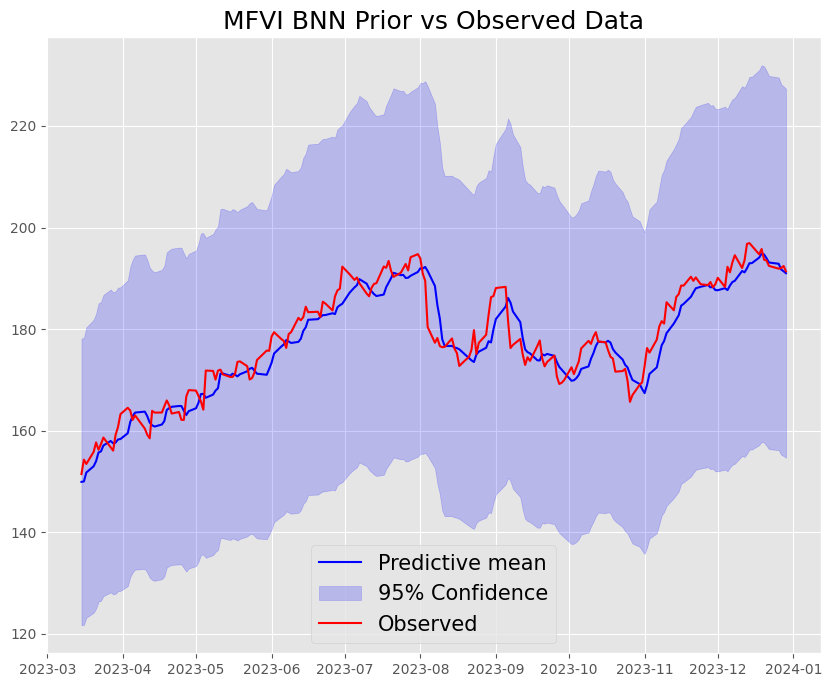

In [641]:
preds = bnn_model(x_te, num_samples=1000).squeeze(-1).detach().numpy()
pred_mean = preds.mean(0)
pred_std = preds.std(0)
plt.plot(data.index[-1*len(pred_mean):], pred_mean, color='blue', label='Predictive mean')
plt.fill_between(data.index[-1*len(pred_mean):], pred_mean + 1.96*pred_std, pred_mean - 1.96*pred_std, color='blue', alpha=0.2, label='95% Confidence')

plt.title("MFVI BNN Prior vs Observed Data", fontsize=18)
plt.plot(data.index[-1*len(pred_mean):], y_te, color='red', label='Observed', zorder=900)
plt.legend(fontsize=15, loc='lower center')
plt.show()